In [4]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf_v1
from sklearn.model_selection import train_test_split

In [5]:
SRC_DIR = os.path.dirname(os.path.abspath("."))
sys.path.insert(0, SRC_DIR)

In [6]:
from src.model import DonkeyNetV0
from src.utils import load_data, blur_img, flip_img, data_generator, clip_steering

# Loading Data

In [13]:
verbose = True
DATA_PATH = r"{PUT_DIR_PATH_OF_YOUR_DATA_HERE}"
img_key, steering_key, throttle_key = "cam/image_array", "user/angle", "user/throttle"

In [14]:
X, Y = load_data(DATA_PATH, img_key=img_key, steering_key=steering_key, throttle_key=throttle_key, 
                 extensions=[".json"], exclude_files=["meta.json"], crop_dim=(slice(20, -10),), 
                 verbose=verbose)
# Filter out throttle readings
Y = np.reshape(Y[:, 0], (len(Y), 1))

Number of files excluded: 1
Found 3314 files with one of these extensions ['.json'] in '/home/rajk/Machine_Learning/DonkeyCar/data'


In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=853)

# Model Initialization

In [16]:
input_shape = X_train[0].shape
loss_func = tf_v1.losses.mean_squared_error
optimizer = tf_v1.train.AdamOptimizer(learning_rate=1e-4)
model = DonkeyNetV0(scope="DonkeyCarModel", input_shape=input_shape, loss_func=loss_func, optimizer=optimizer)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


# Model Training and Testing

In [8]:
SAVE_MODEL_PATH = os.path.join(SRC_DIR, "models", "model.chkpt")
os.makedirs(os.path.dirname(SAVE_MODEL_PATH), exist_ok=True)
GPU_OPTIONS = tf_v1.GPUOptions(per_process_gpu_memory_fraction=0.75)
TF_CONFIG = tf_v1.ConfigProto(gpu_options=GPU_OPTIONS, allow_soft_placement=True)

In [9]:
epochs = 50
with tf_v1.Session(config=TF_CONFIG) as sess:
    sess.run(tf_v1.global_variables_initializer())
    train_data_gen = data_generator(X_train, Y_train, epochs=epochs, batch_size=256, preprocessors=[blur_img, flip_img])
    test_data_gen = data_generator(X_test, Y_test, batch_size=1)
    print("Training the model!")
    train_losses = model.run(sess, data_gen=train_data_gen, training=True)
    print("\nTesting the model")
    test_losses = model.run(sess, data_gen=test_data_gen, training=False)
    model.save_model(sess, SAVE_MODEL_PATH)

Training the model!
Epoch 50 : ██████████████████████████████████████████████████ 100.00% (4863/4863)
Testing the model
Epoch 1  : ██████████████████████████████████████████████████ 100.00% (541/541)

# Training and Testing loss plots

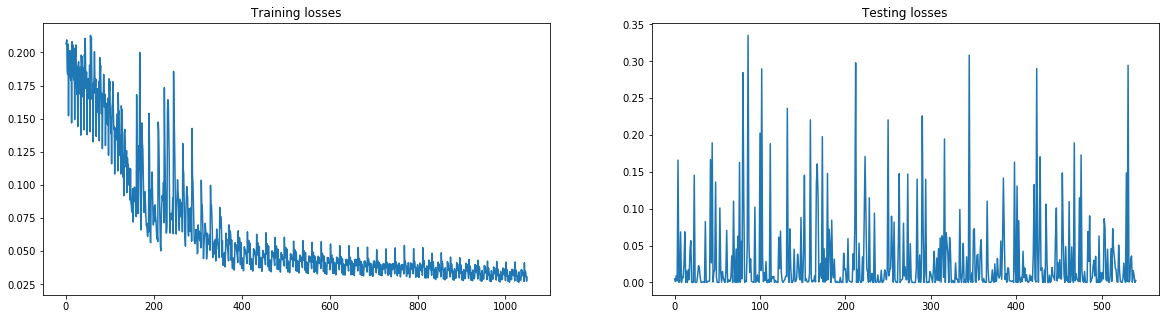

In [10]:
fig, axes = plt.subplots(1, 2, figsize=[20, 5], squeeze=False)
axes[0, 0].set_title("Training losses")
axes[0, 0].plot(train_losses)
axes[0, 1].set_title("Testing losses")
axes[0, 1].plot(test_losses)

# Load Model Parameters

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /home/rajk/Machine_Learning/DonkeyCar Project/models/model.chkpt
Epoch 1  : ██████████████████████████████████████████████████ 100.00% (541/541)

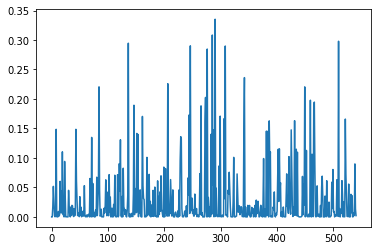

In [11]:
RESTORE_MODEL_PATH = os.path.join(SRC_DIR, "models", "model.chkpt")
with tf_v1.Session(config=TF_CONFIG) as sess:
    sess.run(tf_v1.global_variables_initializer())
    model.restore_model(sess, RESTORE_MODEL_PATH)
    test_data_gen = data_generator(X_test, Y_test, batch_size=1)
    test_losses = model.run(sess, data_gen=test_data_gen, training=False)
plt.plot(test_losses)